In [1]:
#filesystem operations
import subprocess, glob, os, shutil, datetime, re
import pandas as pd
from dateutil import parser
import seaborn as sns


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly

In order for this to work properly, you should enter path to your working folder

In [ ]:
path_to_your_folder=r'C:\My_Sites\qsh2020'

These two folers are needed to download qsh files and convert them to txt format

In [ ]:
#path to the folder where your qsh files are gonna be stored
main_folder=r'C:\My_Sites\qsh2020\erinrv.qscalp.ru'
#path to the folder where your converted to txt files are gonna be stored
target_folder=r'C:\My_Sites\qsh2020\txt_version'

# Part 1: Work with files
 At first, we need to convert batch of files from qsh to txt. There is an util here: https://www.qscalp.ru/download for this purpose. However, we also need to save converted files in a distinct folder.

In [ ]:
path_to_converting_util=r''

Since there is a lot of data at http://erinrv.qscalp.ru/, the following code snippet may be useful. It extracts links from website and writes it in a new tab:


var x = document.querySelectorAll("a");
var myarray = []
for (var i=0; i<x.length; i++){
var nametext = x[i].textContent;
var cleantext = nametext.replace(/\s+/g, ' ').trim();
var cleanlink = x[i].href;
myarray.push([cleantext,cleanlink]);
};
function make_table() {
    var table = '<table><thead><th>Name</th><th>Links</th></thead><tbody>';
   for (var i=0; i<myarray.length; i++) {
            table += '<tr><td>'+myarray[i][1]+'</td></tr>';
    };
 
    var w = window.open("");
w.document.write(table); 
}
make_table()
                                   


At first, we need to convert batch of files from qsh to txt. There is an util here: https://www.qscalp.ru/downloadThen for this purpose. However, we also need to save converted files in a distinct folder.

In [ ]:
def convert_all(path, path_to_converting_util):
    #convert qsh files to txt
    os.chdir(path)
    files=os.listdir(path=".")
    print('list of qsh files:', files)
    for file in files:
        subprocess.run([path_to_converting_util, file])
        print(file, 'converted')
        
        
def move_all_txts(source_dir):
    #make directory named 'copies'
    
    directory = "copies"
    new_dir_path = os.path.join(source_dir, directory) 
    try:
        os.mkdir(new_dir_path) 
    except OSError:
        # The directory already existed, nothing to do
        pass
    files = glob.iglob(os.path.join(source_dir, "*.txt"))
    for txt_file in files:
        shutil.move(txt_file, new_dir_path)



The function below is used to convert files to txt and save them in a separate folder

In [ ]:
def is_stonks(path):
    somestring=path.split('\\')[-1]
    if re.match(r'^[A-Z][A-Z][A-Z][A-Z]\.', somestring):
        return True
    elif re.match(r'^[A-Z][A-Z][A-Z][A-Z][A-Z]\.', file):
        return True
    else:
        return False

    
def convert_and_move(source_folder,dest_folder, path_to_converting_util):
    
    '''this function takes all .qsh files from the source folder, except for those who do not begin with 4 letters.
    Then it converts them to .txt format with given converter.
    Then it cuts and pastes them to destination folder'''
    
    os.chdir(source_folder)
    files=os.listdir(path=".")
    #print('list of qsh files:', files)
    for file in files:
        if is_stonks(file):
            subprocess.run([path_to_converting_util, file])
        #print(file, 'converted')
    files = glob.iglob(os.path.join(source_folder, "*.txt"))
    for txt_file in files:
        shutil.move(txt_file, dest_folder)
    


In [ ]:
#let us delete all non-stock files:
main_folder=r'/run/media/pchome/21F9F94B20E94FA0/My_Sites/qsh2020/try/'

for folder in os.listdir(main_folder):
    for file in os.listdir(os.path.join(main_folder,folder)):
        if re.match(r'^[A-Z][A-Z][A-Z][A-Z]\.', file):
            pass
        elif re.match(r'^[A-Z][A-Z][A-Z][A-Z][A-Z]\.', file):
            pass
        else:
            os.remove(os.path.join(os.path.join(main_folder,folder),file))

This code converts whole stock data folder into similar folder with stock data in .txt format. All the files containing non-stocks data is ignored.

In [ ]:
main_folder=r'C:\My_Sites\qsh2020\erinrv.qscalp.ru'
target_folder=r'C:\My_Sites\qsh2020\txt_version'
for folder in os.listdir(main_folder):
#     print(folder+'!!!')
#     print(os.path.join(main_folder,folder))
    target=os.path.join(target_folder,folder)
    try:
        os.mkdir(target) 
    except OSError:
        print('Despite it should not, the folder '+folder+'somehow managed to exist before you tried to create it! Be cautious!!!')
    convert_and_move(os.path.join(main_folder,folder),target, path_to_converting_util)

# Part 2: Bid-ask spread
In this part I extract bid-ask spread characteristics during daytime. Since I chose to extract mean values during daytime, this may be not representative enough. In addition, work with missing values and 'Unknown' values needs to be done.

In [ ]:
def extract_spread_from_txt_shares_file(file, buffer, where_to_append_result):
    '''At first, we transform raw txt file to a csv-readable form. 
    Then we extract mean relative spread from the file.
    Then we append extracted spread to a new file containing our extracted features.
    Then we delete buffer file.'''
    
    
    # this part extracts best bids+best asks+time into a buffer file
    with open(file, "r") as f:
        rows = f.readlines()
        with open(buffer, "w") as dest:
            cur_bb=None
            cur_ba=None
            dest.write('BestBid,BestAsk,Time\n')
            for row in rows:
                if 'Received' in row:
                    current_time=(parser.parse(row.split(' ')[-1])+datetime.timedelta(hours=10)).time()
                    if not cur_bb:
                        cur_bb="NA,"
                    if not cur_ba:
                        cur_ba="NA,"
                    # we choose to observe only day trade:
                    if current_time>=parser.parse('10:00:00').time() and current_time<parser.parse('18:40:00').time():
                        dest.write(cur_bb+cur_ba+str(current_time)+'\n')
                    cur_bb=None
                    cur_ba=None
                elif 'BestBid' in row:
                    cur_bb=','.join(row.split(';')[1:2]).rstrip()+','
                elif 'BestAsk' in row:
                    cur_ba=','.join(row.split(';')[1:2]).rstrip()+','

                    
    # here I extract name and date from the filename:
#     # windows version:
#     filename=file.split('\\')[-1]
    #linux version:
    filename=file.split('/')[-1]
    name=filename[0:4]
    date=re.findall(r'\d\d\d\d-\d\d-\d\d',filename)[0]
    
     
    
    # this part extracts mean spread
    
    
    data=pd.read_csv(buffer)
    data['Spread']=data['BestAsk']-data['BestBid']
    data['Rel_spread_percents']=50*(data['BestAsk']-data['BestBid'])/(data['BestAsk']+data['BestBid'])
    # spread_mean=data['Spread'].mean()
    rel_spread_mean=data['Rel_spread_percents'].mean()
    rel_spread_median=data['Rel_spread_percents'].median()
    result=pd.DataFrame(np.array([[date, name, rel_spread_mean, rel_spread_median]]))
                       # ,columns=['date','name','mean_relative_spread','median_relative_spread']
    
    # this part appends result to the given file:
    result.to_csv(where_to_append_result, mode='a',header=False,index=False)
    
    #this part deletes buffer file:
    os.remove(buffer)
    

Now we have to iterate through all quotes txt data. Since this step takes several hours, it should be written more efficiently

In [ ]:
#Let us set paths:
#windows version:

# main_folder=r'C:\My_Sites\qsh2020\txt_version'
# buffer=r'C:\My_Sites\qsh2020\buffer\buffer.txt'
# where_to_append_result=r'C:\My_Sites\qsh2020\bid_ask.csv'

#linux version:
main_folder=r'/run/media/pchome/21F9F94B20E94FA0/My_Sites/qsh2020/txt_version'
# main_folder=r'/run/media/pchome/21F9F94B20E94FA0/My_Sites/qsh2020/try/'

buffer=r'/run/media/pchome/21F9F94B20E94FA0/My_Sites/qsh2020/buffer/buffer.txt'
where_to_append_result=r'/run/media/pchome/21F9F94B20E94FA0/My_Sites/qsh2020/bid_ask.csv'


for folder in os.listdir(main_folder):
#     print(folder+'!!!')
#     print(os.path.join(main_folder,folder))
    source=os.path.join(main_folder,folder)
    for filename in os.listdir(source):
        #filename=file.split('\\')[-1]
        if 'Quotes' in filename:
            file=os.path.join(source, filename)
            extract_spread_from_txt_shares_file(file, buffer, where_to_append_result)

### Big picture of median daytime relative bid-ask spreads in 2020:
Here I take a median of relative spread amongst all tickers. Since this is a relative value in percents, the median of relative bid-ask spreads for different tickers may be representative.

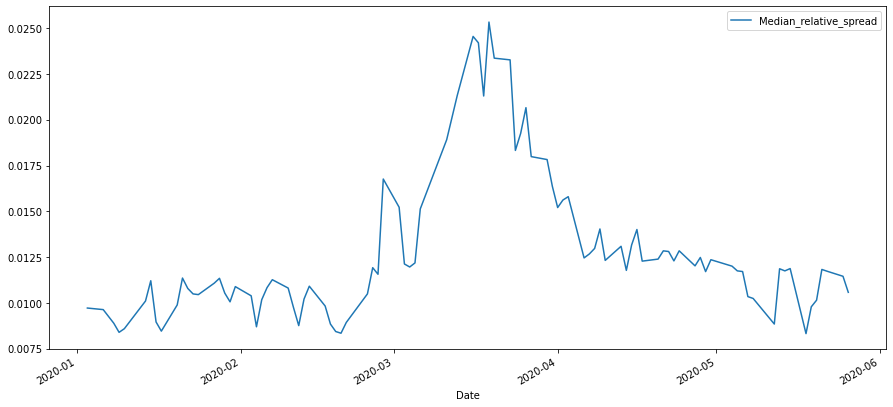

In [8]:
#path
where_to_append_result=r'/run/media/pchome/21F9F94B20E94FA0/My_Sites/qsh2020/bid_ask.csv'


spreads_df=pd.read_csv(where_to_append_result, names=['Date','Ticker','Mean_relative_spread','Median_relative_spread'])
spreads_df['Date']=pd.to_datetime(spreads_df['Date'])

# cleaning
spreads_df.sort_values(by=['Date'], inplace=True)
spreads_df.dropna(how='any', inplace=True)
spreads_df.drop_duplicates(inplace=True)


plt.figure(figsize=(15,7))
spreads_df.groupby('Date')['Median_relative_spread'].median().plot(legend='Relative spread median amongst all stocks')


### Daytime relative bid-ask spreads for different tickers in 2020:
It may be interesting to look at mean bid-ask spreads for different tickers

In [ ]:
# mean relative spread for distinct stocks over tim
for name in sorted(spreads_df['Ticker'].unique()):
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,4))
    fig.suptitle(name)
    ax1.plot(spreads_df[spreads_df['Ticker']==name]['Date'], spreads_df[spreads_df['Ticker']==name]['Mean_relative_spread'],'r')
    ax2.plot(spreads_df[spreads_df['Ticker']==name]['Date'], spreads_df[spreads_df['Ticker']==name]['Median_relative_spread'],'m')
    ax1.legend(['Mean_relative_spread'])
    ax2.legend(['Median_relative_spread'])
    plt.show()
# monthly_mean.plot(x=df.index, y='A')

# Part 3: Volume and turnover
Here I extract daytime trade volume. The turnover rate from this article https://www.imf.org/external/pubs/ft/wp/2002/wp02232.pdf is defined as: 

![title](img/volume_turn.png)

(article pages 12-14)

However, there is a **problem**: I didn't manage to extract the **outstanding stock of the asset (S)** from the data. This is why in this case, the Turnover is defined as:

\begin{equation}
\Large Tn(date))=\frac{\sum_{t\in date}P_t*Q_t}{\overline{P}_{date}}
\end{equation}


The following code extracts the volume and turnover (without the S parameter) to a new file. These parameters are calculated over daytime, and then written to the *target* file in a csv format.

At first, we need to set path to the files we work with:

In [9]:
#windows version:

# new_path=r'C:\My_Sites\qsh2020\txt_version\2020-01-09\AFLT.2020-01-09.Deals.{1-Deals}.txt'
# # target=r'C:\My_Sites\qsh2020\new_data.csv'
# target=r'C:\My_Sites\qsh2020\volume_and_turnover.csv'

#linux version:

main_folder=r'/run/media/pchome/21F9F94B20E94FA0/My_Sites/qsh2020/txt_version'
where_to_save=r'/run/media/pchome/21F9F94B20E94FA0/My_Sites/qsh2020/volume_and_avg_price.csv'


This code analyses 'Deals' files from the 'main_folder' and extracts volume and average prices to the file which is denoted as 'where_to_save'.

In [ ]:
def extract_volume_and_avg_price(file, where_to_save):
    #at first, we need to calculate volume and turnover rate
    deals=pd.read_csv(file, sep=';',header=1)
    volume=(deals['Price']*deals['Volume']).sum()
    avg_price=deals['Price'].mean()

    #get name of stock and date
#     #windows version:
#     filename=file.split('\\')[-1]
    #linux version:
    filename=file.split('/')[-1]
    name=filename[0:4]
    date=re.findall(r'\d\d\d\d-\d\d-\d\d',filename)[0]
    
    # write down data to a new file
    result=pd.DataFrame(np.array([[date, name, volume, avg_price]]))

    # this part appends result to the given file:
    result.to_csv(where_to_save, mode='a',header=False,index=False)
    
    
    

for folder in os.listdir(main_folder):
#     print(folder+'!!!')
#     print(os.path.join(main_folder,folder))
    source=os.path.join(main_folder,folder)
    for filename in os.listdir(source):
        #filename=file.split('\\')[-1]
        if 'Deals' in filename:
            file=os.path.join(source, filename)
            #extract_spread_from_txt_shares_file(file, buffer, where_to_append_result)
            extract_volume_and_avg_price(file, where_to_save)

Time to plot volume and turnover rates for 2020! Here is the code:

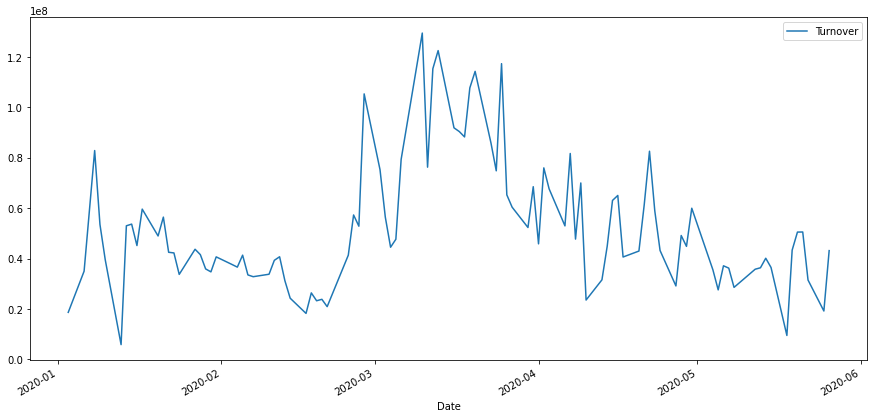

In [10]:
volume_df=pd.read_csv(where_to_save, names=['Date','Ticker','Volume', 'Avg_price'])

plt.figure(figsize=(15,7))

volume_df['Date']=pd.to_datetime(volume_df['Date'])
volume_df.sort_values(by=['Date'], inplace=True)

# WHAT ABOUT THE S PARAMETER??????
volume_df['Turnover']=volume_df['Volume']/volume_df['Avg_price']

volume_df.groupby('Date')['Turnover'].sum().plot(legend=True)


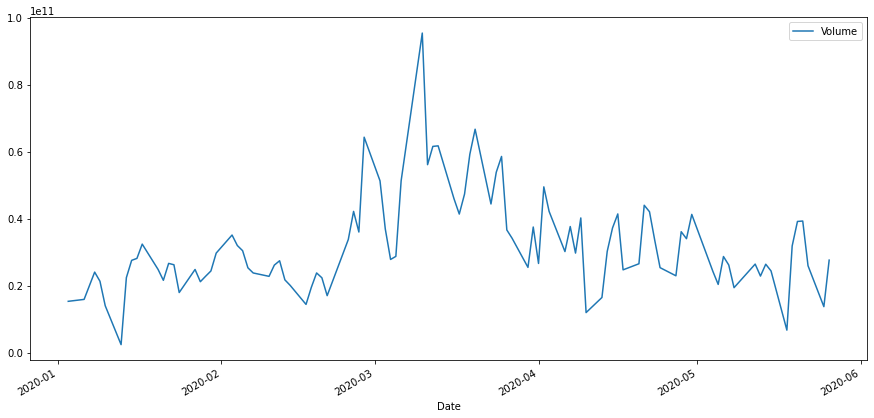

In [11]:
plt.figure(figsize=(15,7))
volume_df.groupby('Date')['Volume'].sum().plot(legend=True)

It may be interesting to look at distinct graphs for different tickers. The following code gives a pair of graphs with volume and turnover for each ticker:

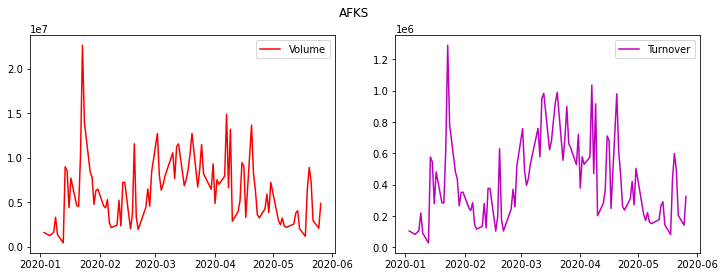

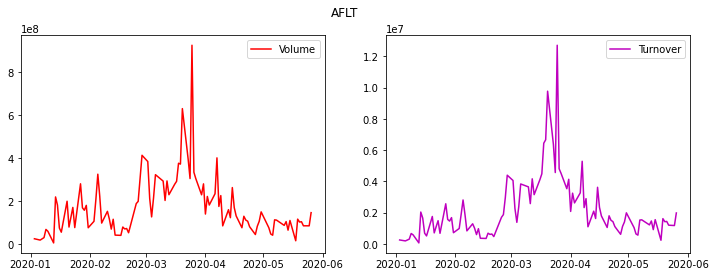

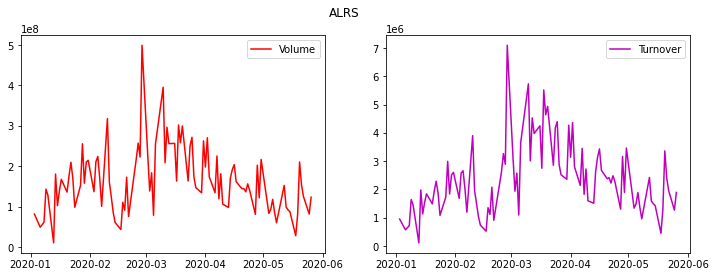

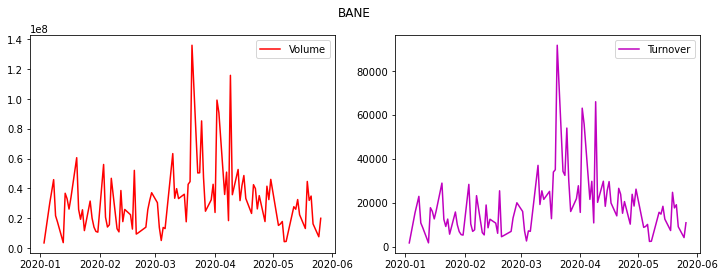

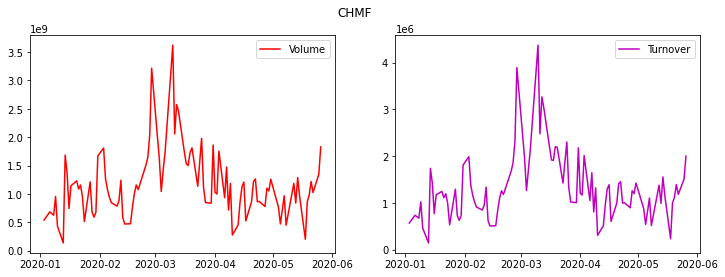

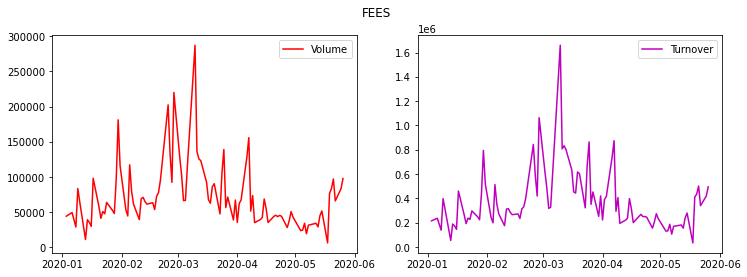

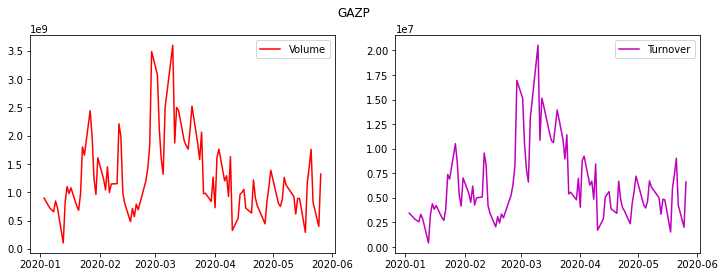

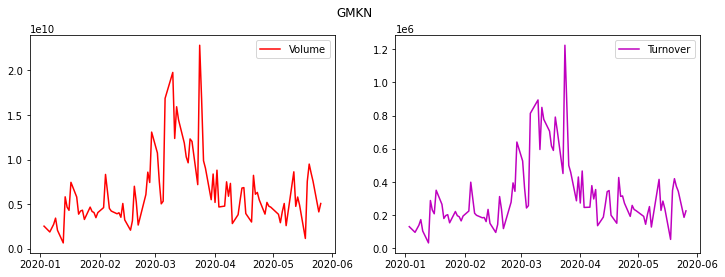

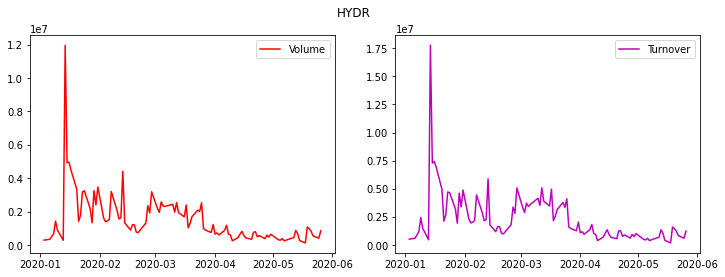

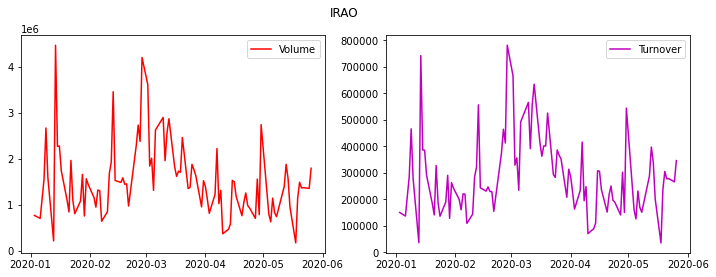

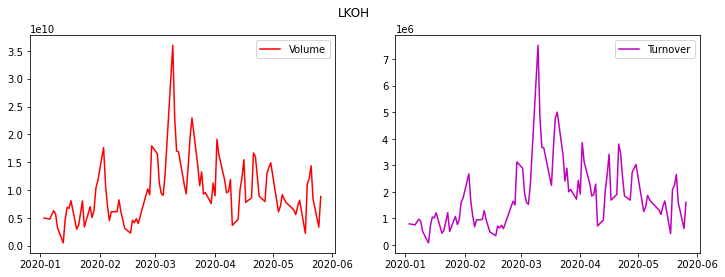

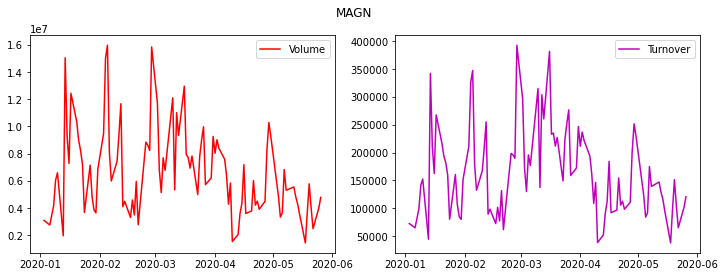

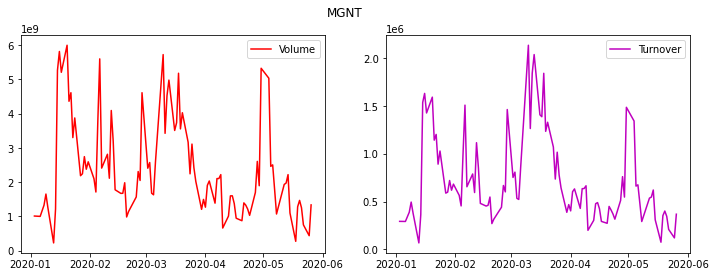

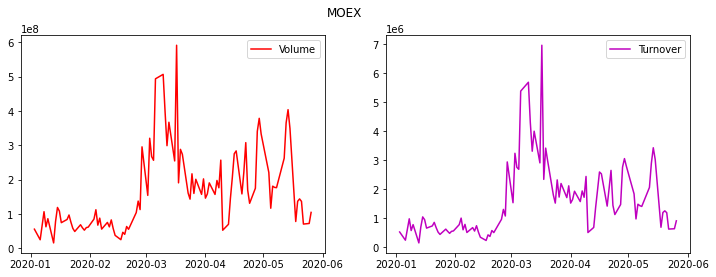

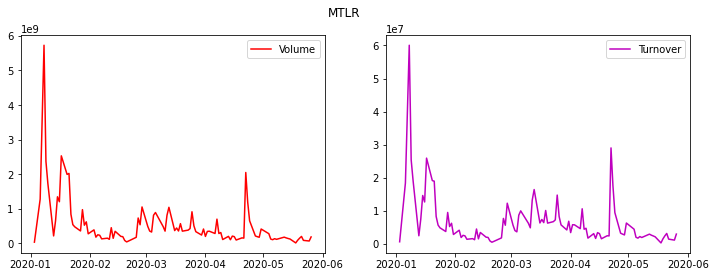

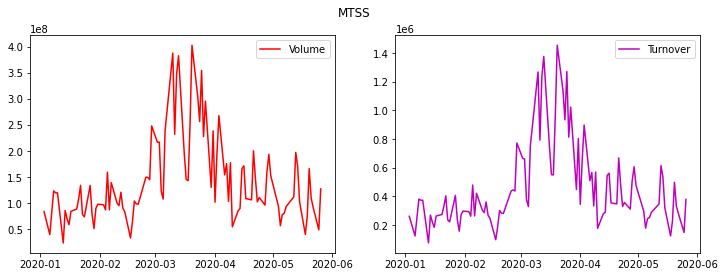

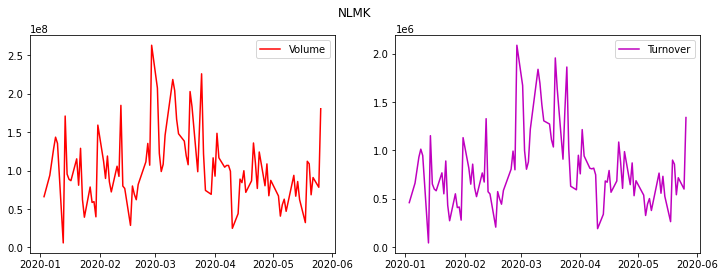

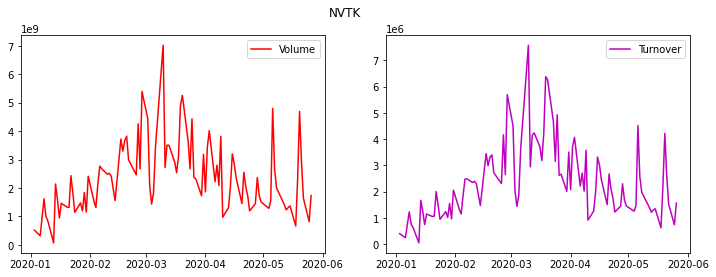

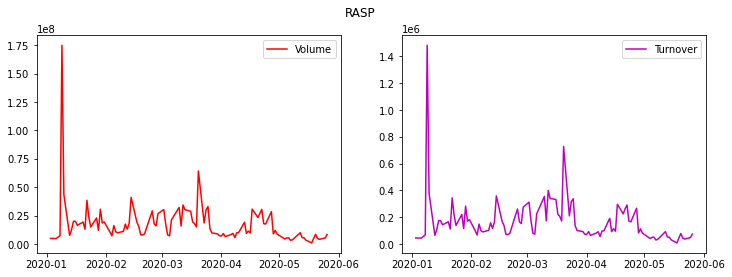

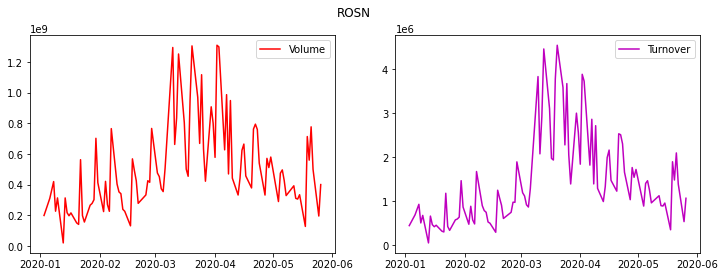

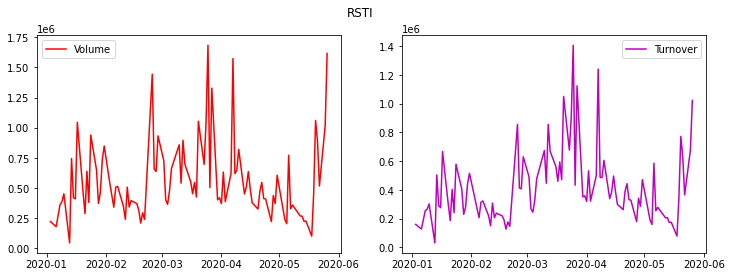

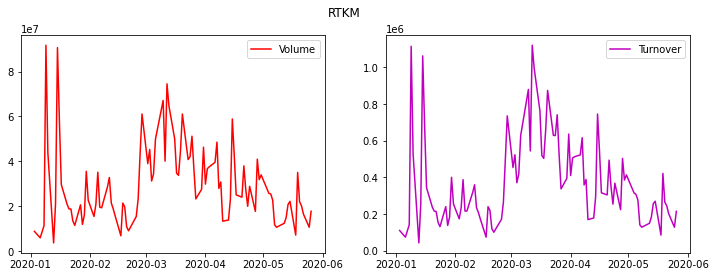

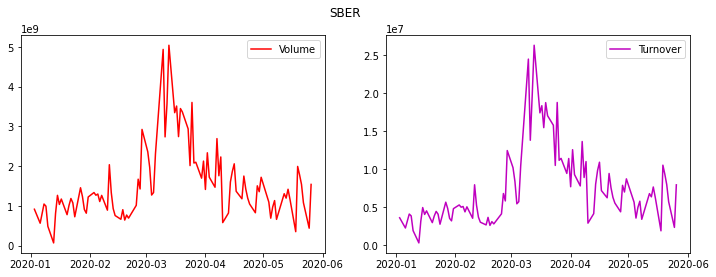

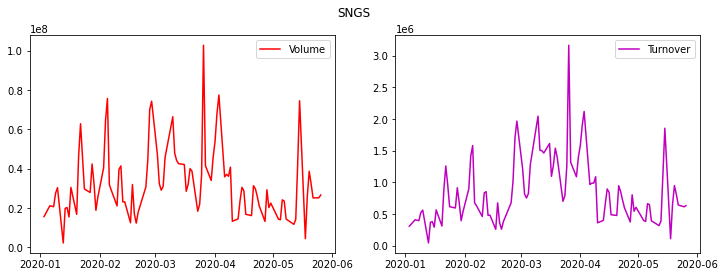

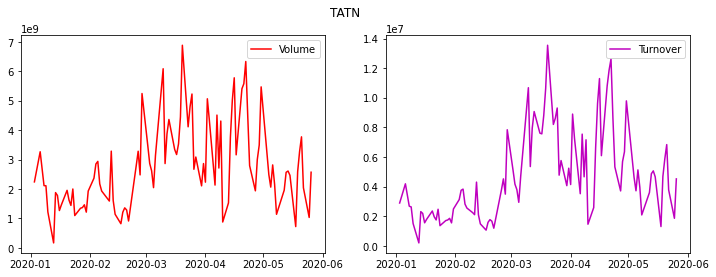

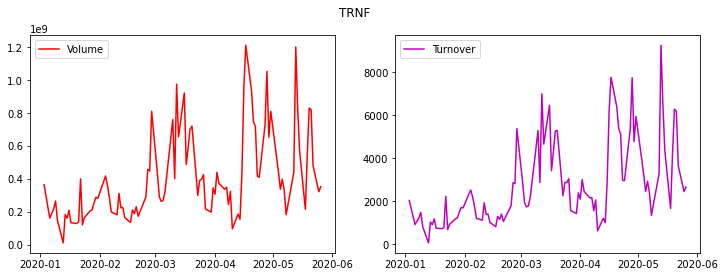

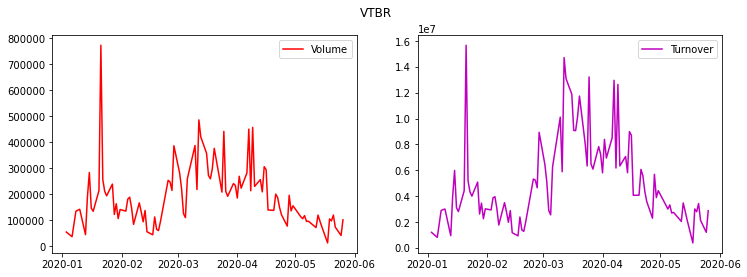

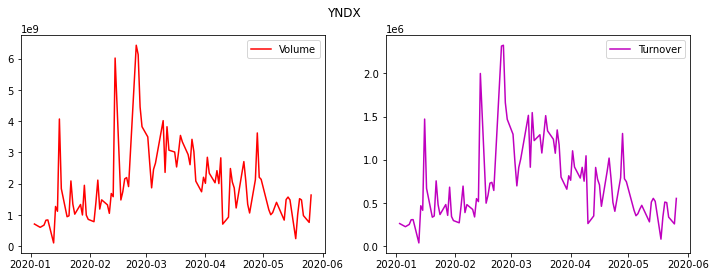

In [12]:
for name in sorted(volume_df['Ticker'].unique()):
#     plt.plot(df[df['Ticker']==name].index, df[df['Ticker']==name]['Volume'],'r')
#     plt.plot(df[df['Ticker']==name].index, df[df['Ticker']==name]['Turnover'],'m')
    
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
    fig.suptitle(name)
    ax1.plot(volume_df[volume_df['Ticker']==name]['Date'], volume_df[volume_df['Ticker']==name]['Volume'],'r')
    ax2.plot(volume_df[volume_df['Ticker']==name]['Date'], volume_df[volume_df['Ticker']==name]['Turnover'],'m')
    
    ax1.legend(['Volume'])
    ax2.legend(['Turnover'])

    plt.show()

We can clearly see that Volume and Turnover rate do correlate very much. 

# Part 4: The Hui-Heubel Liquidity Ratio

![title](img/Hui.png)

At as usually, we need to set path to the files we work with:

In [14]:
# linux version

main_folder=r'/run/media/pchome/21F9F94B20E94FA0/My_Sites/qsh2020/txt_version'
where_to_save_prices_for_Lhh=r'/run/media/pchome/21F9F94B20E94FA0/My_Sites/qsh2020/prices_for_Lhh.csv'


In [ ]:
def extract_prices(file, where_to_save):
    
    #at first, we need to calculate  min, max, and closing prices
    df=pd.read_csv(file, sep=';',header=1)
    df=df.dropna(how='any')
    max_price,min_price,closing_price=df['Price'].max(),df['Price'].min(),df.iloc[-1]['Price']


#     # get name of stock and date: windows version
    
#     filename=file.split('\\')[-1]
#     name=filename[0:4]
#     date=re.findall(r'\d\d\d\d-\d\d-\d\d',filename)[0]

    #get name of stock and date: linux version
    
    filename=file.split('/')[-1]
    name=filename[0:4]
    date=re.findall(r'\d\d\d\d-\d\d-\d\d',filename)[0]
    
    # write down data to a new file
    
    result=pd.DataFrame(np.array([[date, name, max_price, min_price, closing_price]])
                        ,columns=['Date','Ticker','Max_price', 'Min_price', 'Closing_price'])
    
    # this part appends result to the given file:
    result.to_csv(where_to_save, mode='a',header=False,index=False)

    

for folder in os.listdir(main_folder):
#     print(folder+'!!!')
#     print(os.path.join(main_folder,folder))
    source=os.path.join(main_folder,folder)
    for filename in os.listdir(source):
        #filename=file.split('\\')[-1]
        if 'Deals' in filename:
            file=os.path.join(source, filename)
            extract_prices(file, where_to_save_prices_for_Lhh)

Let us do a little exploratory part. In detail, the following code makes plots with prices for different tickers:

In [15]:
#data_cleaning 
prices_df=pd.read_csv(where_to_save_prices_for_Lhh, names=['Date','Ticker','Max_price', 'Min_price', 'Closing_price'])
prices_df['Date']=pd.to_datetime(prices_df['Date'])
prices_df.sort_values(by=['Date'], inplace=True)
prices_df.dropna(how='any', inplace=True)
prices_df.drop_duplicates(inplace=True)

# #plots for distinct tickers
# for name in sorted(prices_df['Ticker'].unique()):
#     fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(18,4))
#     fig.suptitle(name)
#     ax1.plot(prices_df[prices_df['Ticker']==name]['Date'], prices_df[prices_df['Ticker']==name]['Max_price'],'r')
#     ax2.plot(prices_df[prices_df['Ticker']==name]['Date'], prices_df[prices_df['Ticker']==name]['Min_price'],'m')
#     ax3.plot(prices_df[prices_df['Ticker']==name]['Date'], prices_df[prices_df['Ticker']==name]['Closing_price'],'g')
#     ax1.legend(['Max_price'])
#     ax2.legend(['Min_price'])
#     ax3.legend(['Closing_price'])
#     plt.show()

Time to make some rolling functions in order to calculate minimal and maximal prices over 5 days!

now I need to wrap it into a function, in order to extract median values for the whole market


In [49]:
def make_normed_Lhh(name):
    dataframe=prices_df[prices_df['Ticker']==name]
    # dataframe.head(10)
    date = dataframe['Date']
    rolling_max = dataframe['Max_price'].rolling(5).max()
    rolling_min = dataframe['Min_price'].rolling(5).min()
    rolling_avg_closing_price = dataframe['Closing_price'].rolling(5).mean()

    new_df = pd.DataFrame({'Date':date,
                           'RMaxP':rolling_max,
                           'RMinP':rolling_min,
                           'RMeanClP':rolling_avg_closing_price}
                         ).set_index('Date')


    #This part adds the row with trade volumes into the dataset
    dataframe=dataframe.set_index('Date')
    dataframe['Volume']=volume_df[volume_df['Ticker']==name].set_index('Date')['Volume']
    rolling_sum_volume=dataframe['Volume'].rolling(5).sum()
    new_df['Volume']=rolling_sum_volume


    # new_df['Lhh']=(rolling_max-rolling_min)*rolling_avg_closing_price/(rolling_min*rolling_sum_volume)
    new_df['Lhh']=(new_df['RMaxP']-new_df['RMinP'])*new_df['RMeanClP']/(new_df['RMinP']*new_df['Volume'])
    new_df['normed_Lhh']=new_df['Lhh']/(new_df['Lhh'].mean())
#     new_df['Ticker']=name
    return new_df['normed_Lhh']


In [ ]:
# new_df['normed_Lhh'] = (new_df['Lhh']*new_df['Volume'].mean()/1000)
# plt.figure(figsize=(16,7))
# plt.plot(new_df.index, new_df['normed_Lhh'], 'b')
# plt.legend(['normed HH-Liquidity metric'])
# plt.xticks(rotation=45)
# plt.show()


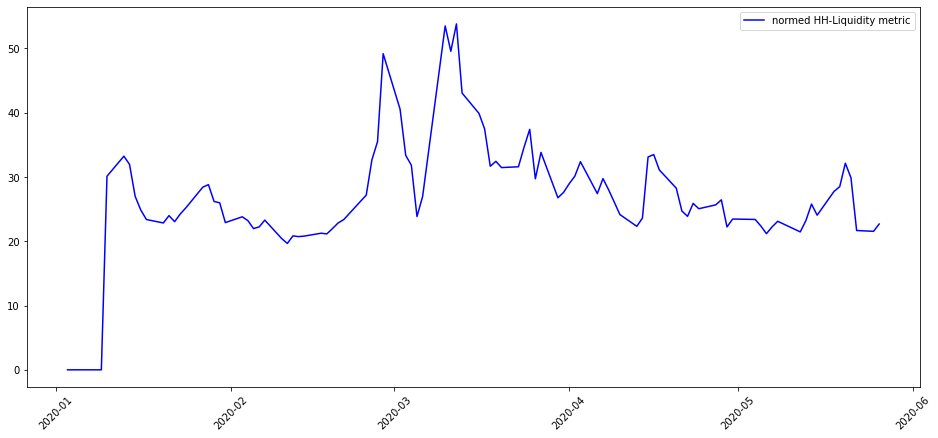

In [50]:
lhhs_df=pd.DataFrame()
for name in prices_df['Ticker'].unique():
    try:
        lhhs_df[name] = make_normed_Lhh(name)
    except ValueError as err:
        print(err)
sum_lhh=lhhs_df.sum(axis=1)
plt.figure(figsize=(16,7))
plt.plot(sum_lhh.index, sum_lhh, 'b')
plt.legend(['normed HH-Liquidity metric'])
plt.xticks(rotation=45)
plt.show()

In [52]:
lhhs_df

AFKS      YNDX      VTBR      TRNF      TATN      SNGS  \
Date                                                                     
2020-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
2020-01-06       NaN       NaN       NaN       NaN       NaN       NaN   
2020-01-08       NaN       NaN       NaN       NaN       NaN       NaN   
2020-01-09       NaN       NaN       NaN       NaN       NaN       NaN   
2020-01-10  0.947401  1.392098  1.127868  0.939735  0.745597  1.126778   
...              ...       ...       ...       ...       ...       ...   
2020-05-20  1.081785  1.546032  1.148812  0.452230  0.976846  1.037185   
2020-05-21  0.912820  1.501466  0.865049  0.299888  0.890866  0.521421   
2020-05-22  0.611552  0.937899  0.638399  0.309932  0.681580  0.962251   
2020-05-25  0.594736  0.854133  0.596659  0.288571  0.666859  0.918926   
2020-05-26  0.632456  0.766597  0.696269  0.255083  0.676117  1.149660   

                RTKM      RSTI      NVTK      NLMK  ...      ALRS      BANE  \
Date                                                ...                       
2020-01-03       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2020-01-06       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2020-01-08       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2020-01-09       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2020-01-10  0.862270  1.510043  1.981436  0.644283  ...  1.293433  0.689495   
...              ...       ...       ...       ...  ...       ...       ...   
2020-05-20  0.920360  0.884349  1.455653  1.603272  ...  1.038846  0.508013   
2020-05-21  0.694107  0.929837  1.192881  1.567337  ...  1.088364  0.467410   
2020-05-22  0.731989  0.780661  0.808328  0.768545  ...  0.770698  0.488370   
2020-05-25  0.706662  0.967860  0.724872  1.015433  ...  0.712851  0.495680   
2020-05-26  0.713587  0.999363  0.689357  1.159886  ...  0.783991  0.608983   

                FEES      GAZP      CHMF      MOEX      RASP      SBER  \
Date                                                                     
2020-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
2020-01-06       NaN       NaN       NaN       NaN       NaN       NaN   
2020-01-08       NaN       NaN       NaN       NaN       NaN       NaN   
2020-01-09       NaN       NaN       NaN       NaN       NaN       NaN   
2020-01-10  0.780545  1.127056  0.971814  1.631604  0.597543  1.214284   
...              ...       ...       ...       ...       ...       ...   
2020-05-20  0.816088  1.384275  1.702174  0.530084  1.692519  0.747667   
2020-05-21  0.934052  1.156138  1.858571  0.629629  1.701744  0.903052   
2020-05-22  0.755656  0.726795  1.037819  0.477821  1.059552  0.675747   
2020-05-25  0.708727  0.594495  1.090967  0.482741  1.081599  0.668535   
2020-05-26  0.580200  0.773220  1.174415  0.547358  1.284601  0.719671   

                HYDR      GMKN  
Date                            
2020-01-03       NaN       NaN  
2020-01-06       NaN       NaN  
2020-01-08       NaN       NaN  
2020-01-09       NaN       NaN  
2020-01-10  1.050432  0.987405  
...              ...       ...  
2020-05-20  1.574179  1.850083  
2020-05-21  1.369818  1.602273  
2020-05-22  0.989900  0.874484  
2020-05-25  0.918859  0.802634  
2020-05-26  1.232193  0.776912  

[98 rows x 28 columns]

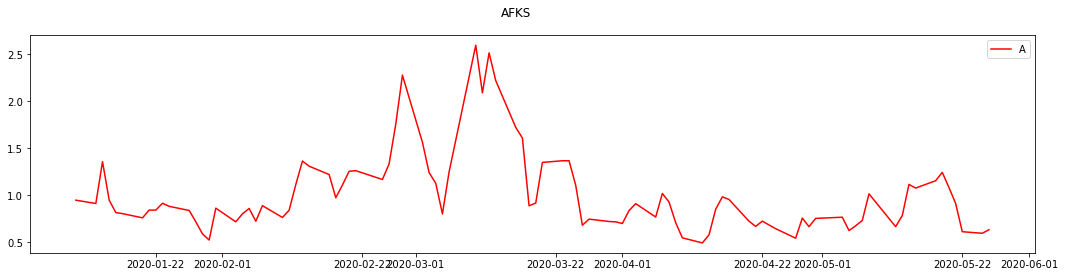

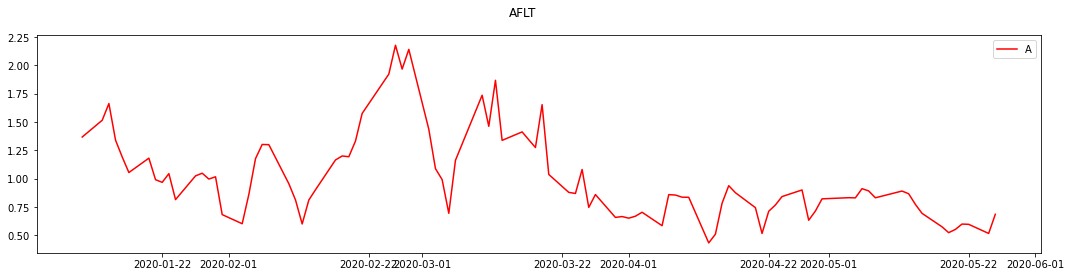

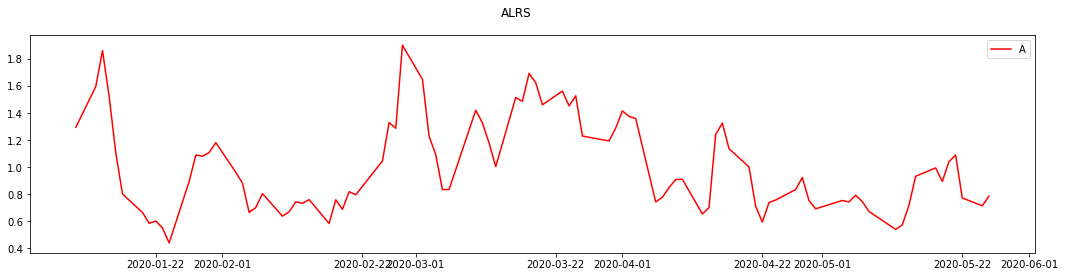

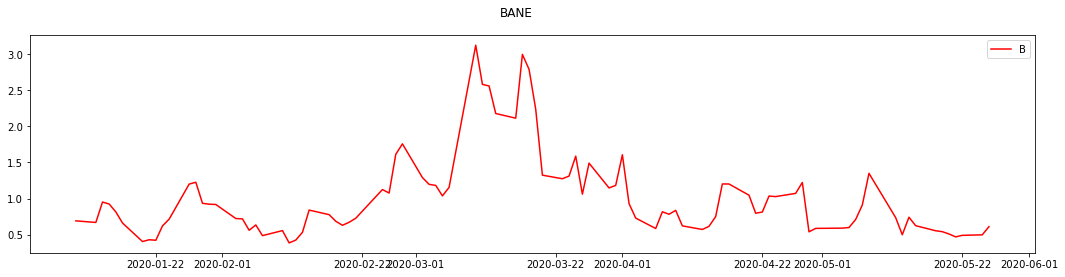

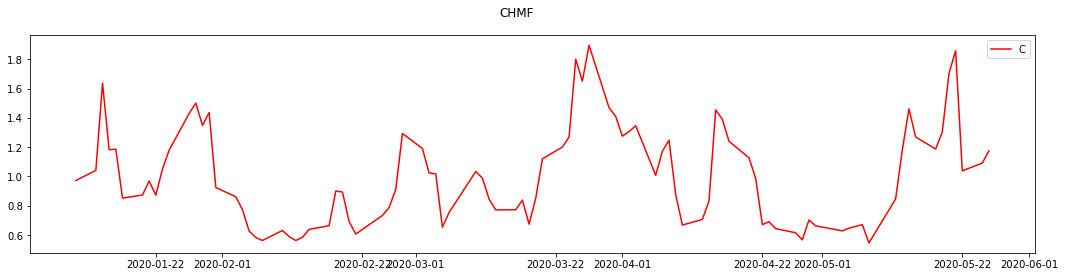

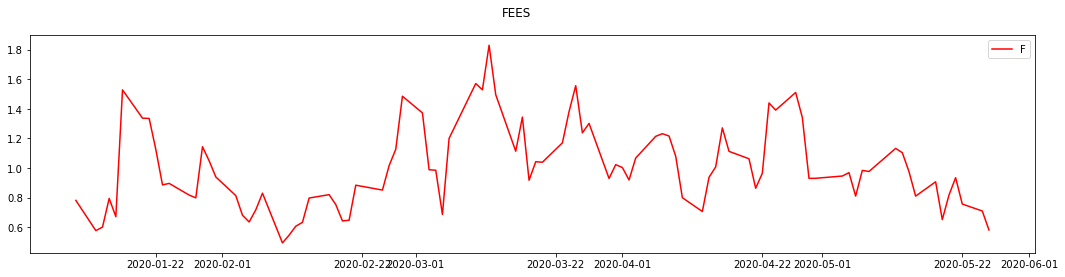

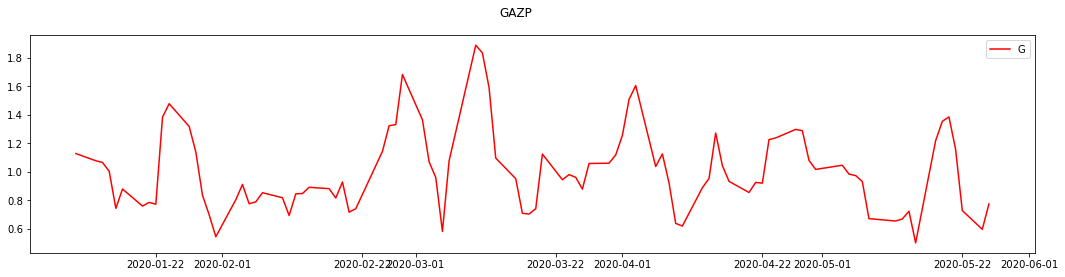

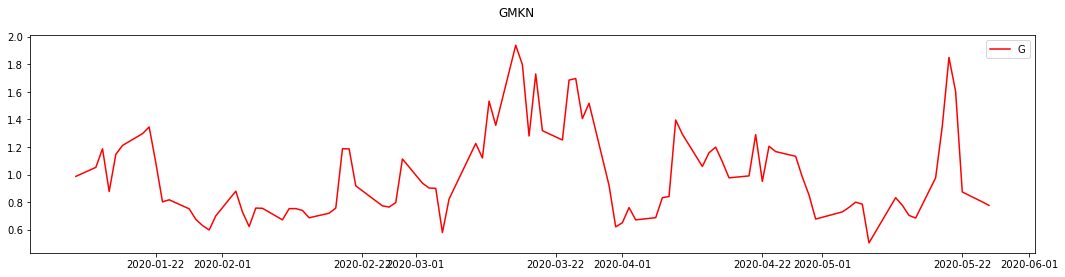

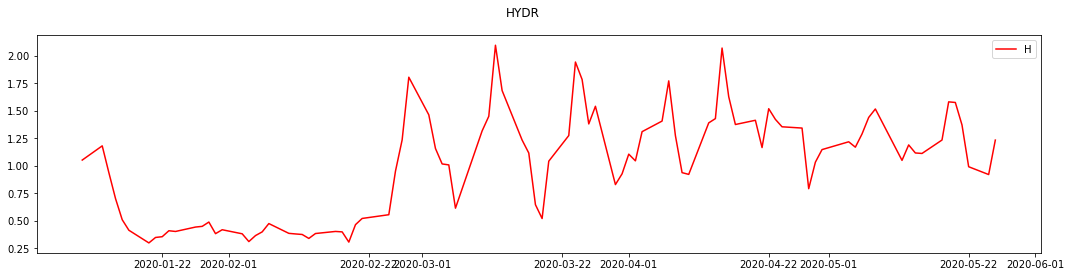

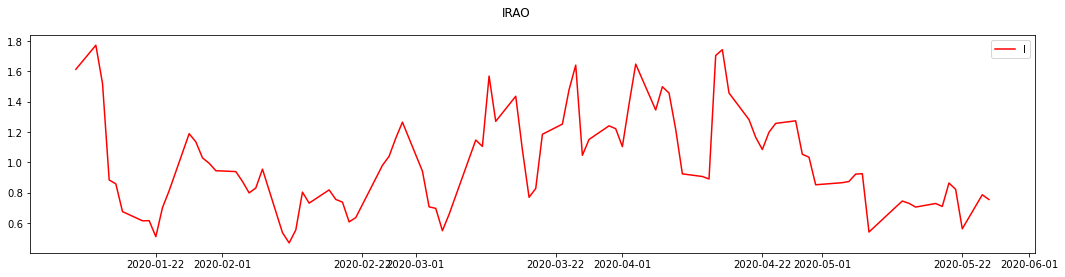

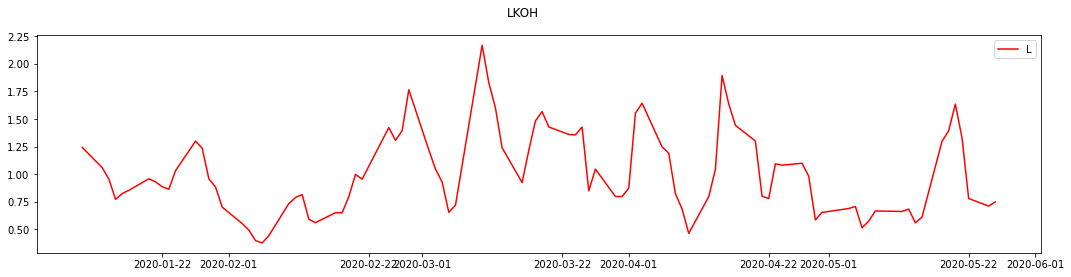

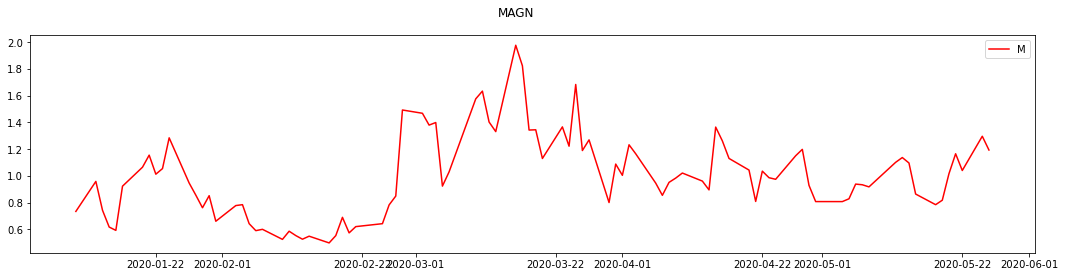

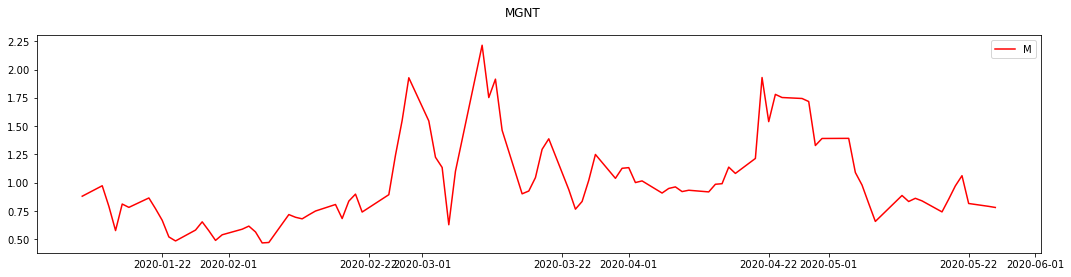

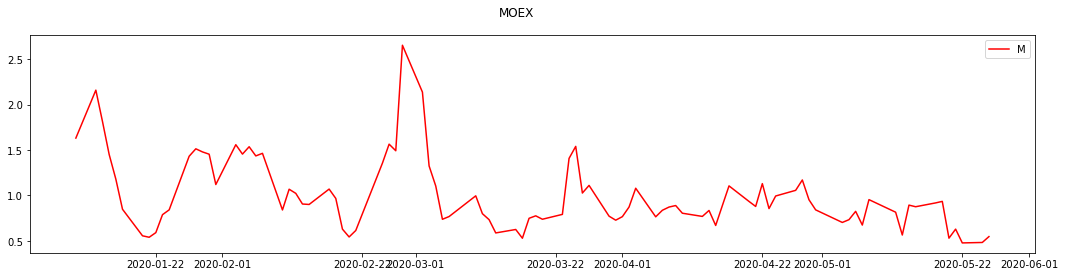

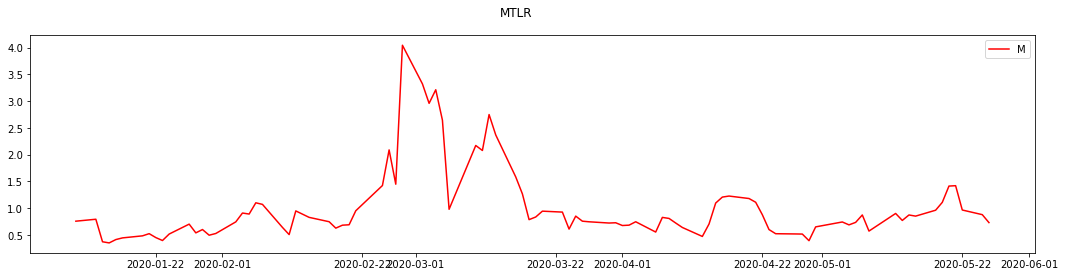

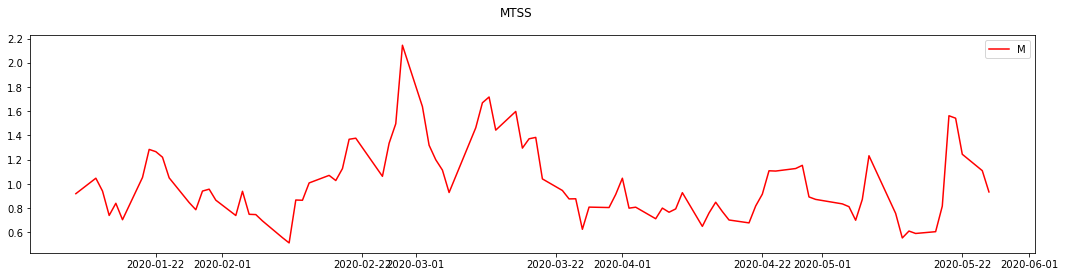

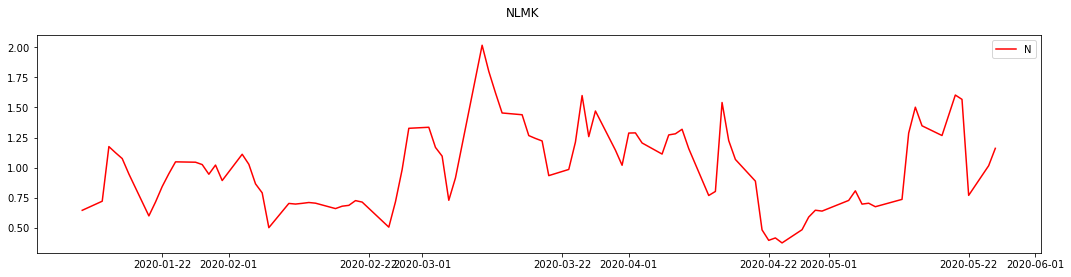

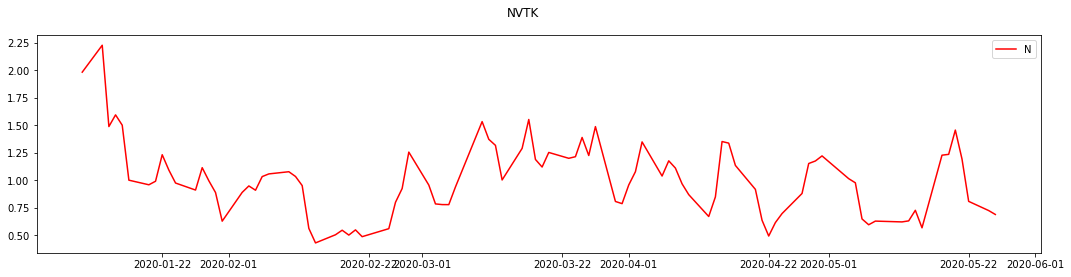

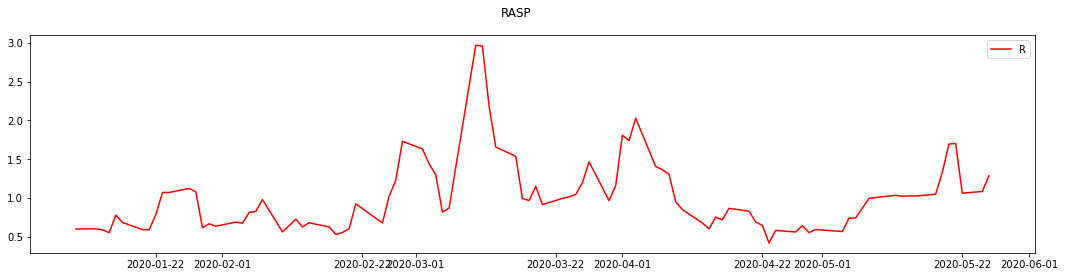

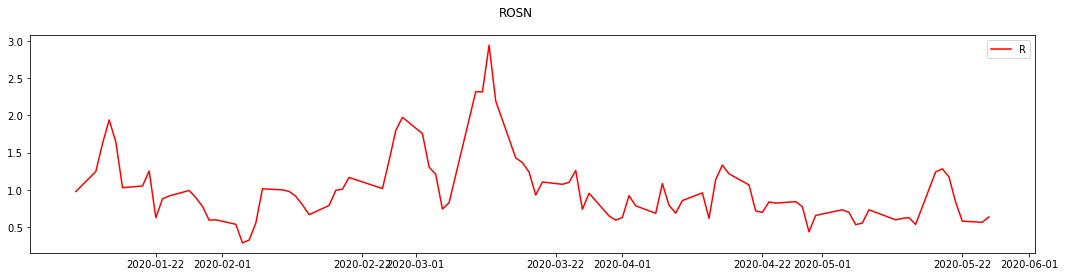

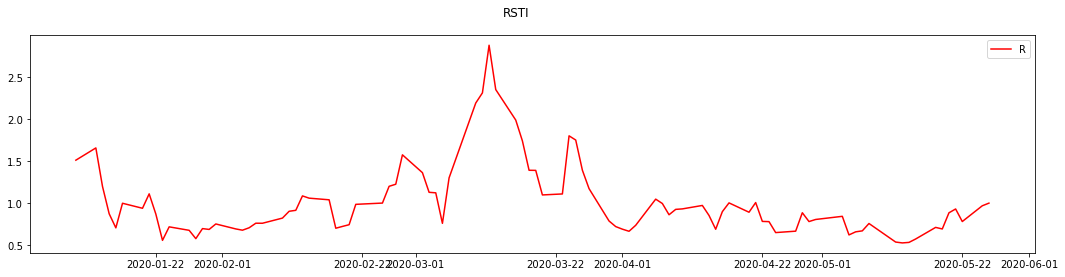

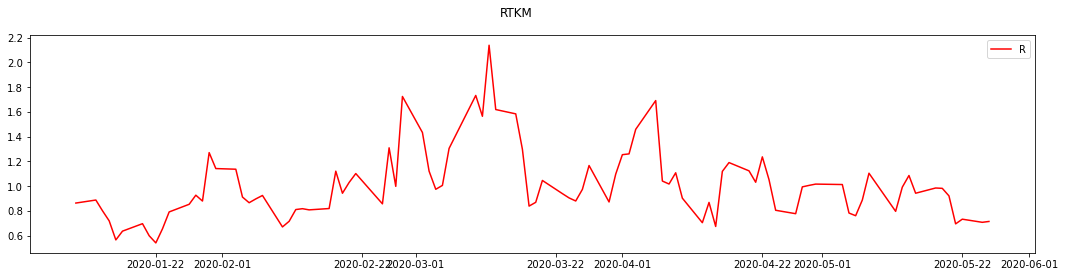

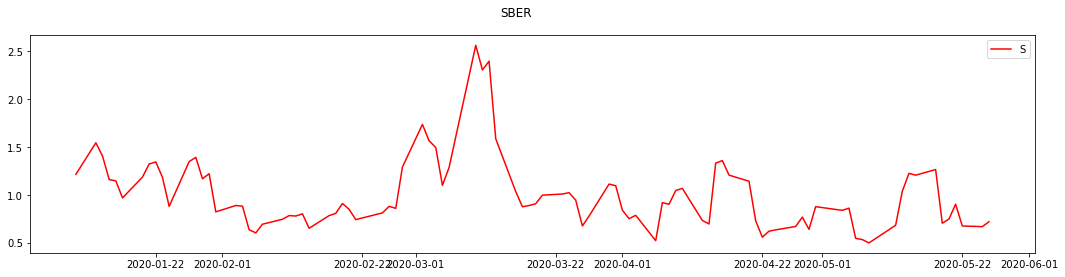

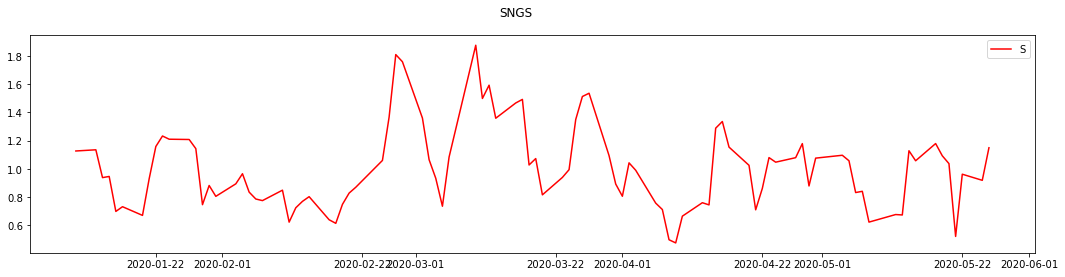

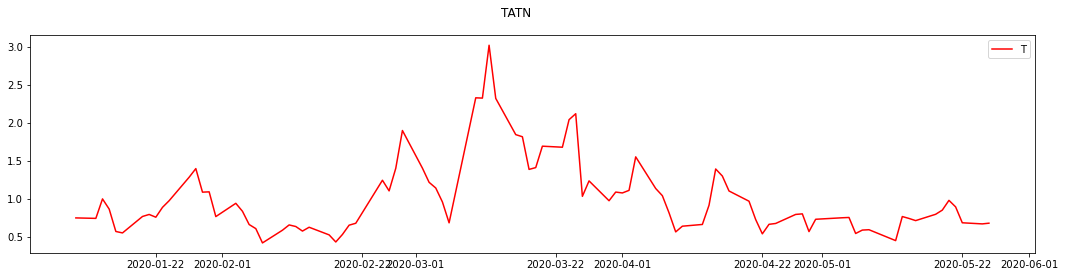

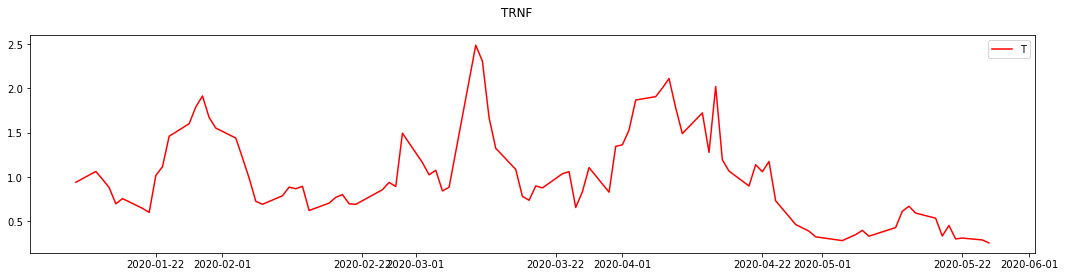

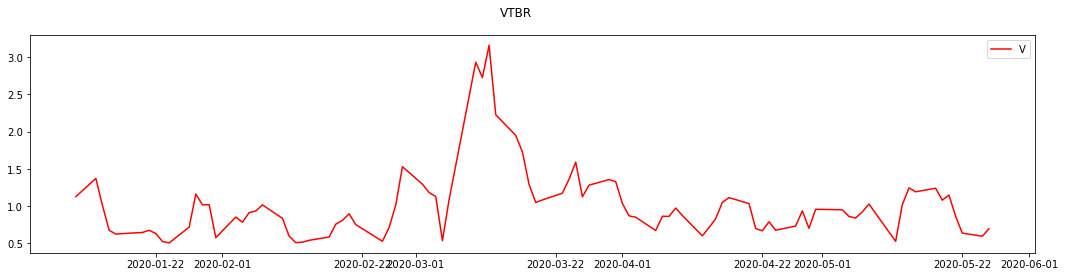

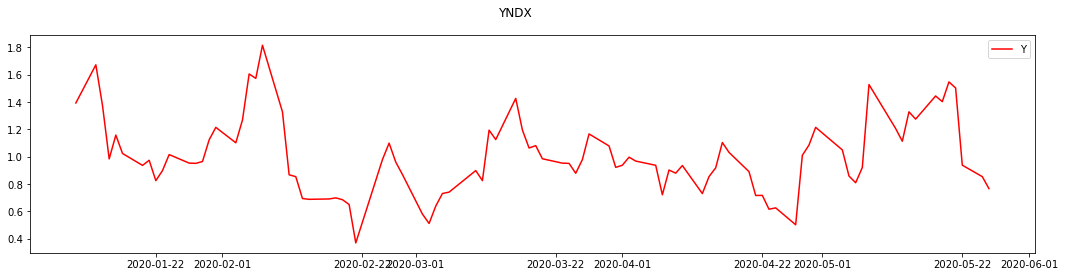

In [53]:
for name in sorted(prices_df['Ticker'].unique()):
    fig, ax1 = plt.subplots(1, 1,figsize=(18,4))
    fig.suptitle(name)
    ax1.plot(lhhs_df.index, lhhs_df[name],'r')
    ax1.legend(name)
    plt.show()

# Part 5: my own metrics

### Firstly, 
the volume of trades would probably be more useful, if I would plot its moving averages.

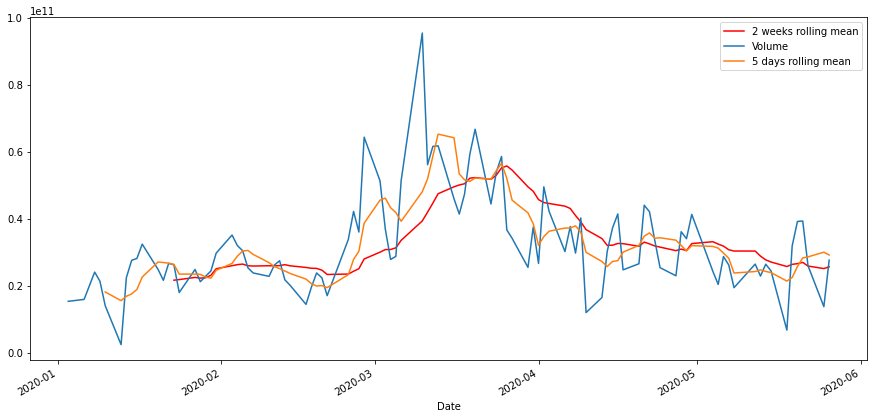

In [54]:
plt.figure(figsize=(15,7))
volume_df.groupby('Date')['Volume'].sum().rolling(14).mean().plot(legend=True, color='r',label="2 weeks rolling mean")
volume_df.groupby('Date')['Volume'].sum().plot(legend=True,label="Volume")
volume_df.groupby('Date')['Volume'].sum().rolling(5).mean().plot(legend=True,label="5 days rolling mean")


Whenever the short-term moving average intersects long-term moving average, we can suppose that liquidity will significantly change next 2 weeks.

### Secondly, 
since liquidity depends on the ease of selling assets, the delay between the time an Ask is received and the deal time may be useful. 

In [ ]:
delays_csv=r'/run/media/pchome/21F9F94B20E94FA0/My_Sites/qsh2020/delays.csv'

def extract_waiting_time_stats(file, filename, where_to_save):
    deals=pd.read_csv(file, sep=';',header=1)
    deals=deals[deals['Type']=='Sell']
    deals['Delay']=(pd.to_datetime(deals['Received'])
                    -pd.to_datetime(deals['ExchTime'])+datetime.timedelta(hours=11)).dt.total_seconds()
    
    # filename=file.split('/')[-1]
    name=filename[0:4]
    date=re.findall(r'\d\d\d\d-\d\d-\d\d',filename)[0]
    avg_delay, min_delay, max_delay, median_delay = deals['Delay'].mean(), deals['Delay'].median(), deals['Delay'].min(), deals['Delay'].max()
    # write down data to a new file
    result=pd.DataFrame(np.array([[date, name, avg_delay, median_delay, min_delay, max_delay]]))
    # this part appends result to the given file:
    result.to_csv(where_to_save, mode='a',header=False,index=False)
    

# start_time = timeit.default_timer()
# where_to_save=r'/run/media/pchome/21F9F94B20E94FA0/My_Sites/qsh2020/delays.csv'
# extract_waiting_time_stats(example, 'AFKS.2020-01-23.Deals.{1-Deals}.txt', where_to_save)
# print(timeit.default_timer() - start_time)
for folder in os.listdir(main_folder):
#     print(folder+'!!!')
#     print(os.path.join(main_folder,folder))
    source=os.path.join(main_folder,folder)
    for filename in os.listdir(source):
        #filename=file.split('\\')[-1]
        if 'Deals' in filename:
            file=os.path.join(source, filename)
            #extract_spread_from_txt_shares_file(file, buffer, where_to_append_result)
            extract_waiting_time_stats(file, filename, delays_csv)

In [ ]:
delays_df = pd.read_csv(delays_csv, names=['Date','Ticker','Avg_delay', 'Median_delay','Min_delay', 'Max_delay'])
delays_df['Date']=pd.to_datetime(delays_df['Date'])

# cleaning
delays_df.sort_values(by=['Date'], inplace=True)
delays_df.dropna(how='any', inplace=True)
delays_df.drop_duplicates(inplace=True)

delays_df[(delays_df['Ticker']=='VTBR')&(delays_df['Median_delay'].between(-10,10))].set_index('Date').plot()

This approach seems to be useless, and the time difference changes by 1hr in the middle of data.

# Part 6: conclusions and metrics ranking

We can clearly see that the median relative bid-ask spread, turnover rate and volume of trades indicate a considerable leap in liquidity in april. However, the median relative bid-ask spread indicates the trend more clearly. The Hui-Huebel liquidity metric turned out to not indicate anything at all. Accordingly, it follows that metrics may be ranked in the following way:
1. Mean relative bid-ask spread (the mean and the median are taken amongst all stocks) - works properly and is already widely used as a liquidity metric
2. Turnover rate and the volume of trades - indicate a trend and look useful
3. Intersections of moving averages for the volume of trades indicate changes in trends
3. Hui-Huebel metric seems to indicate a rise of liquidity in the beginning of March, but looks generally obscure
4. Duration of waiting seems to be useless and unclear

These are the metrics worth looking at:

## Mean relative spreads:

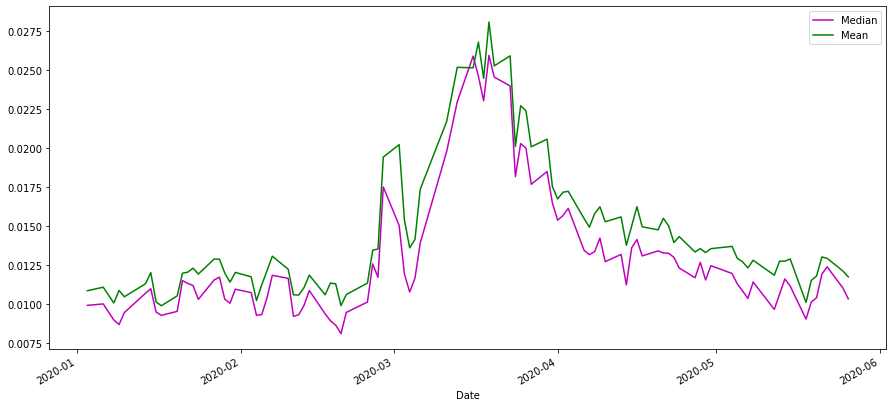

In [68]:
plt.figure(figsize=(15,7))
spreads_df.groupby('Date')['Mean_relative_spread'].median()\
.plot(color='m',label='Median',legend=True)
spreads_df.groupby('Date')['Mean_relative_spread'].mean()\
.plot(color='g',label='Mean',legend=True)


## Turnover rate

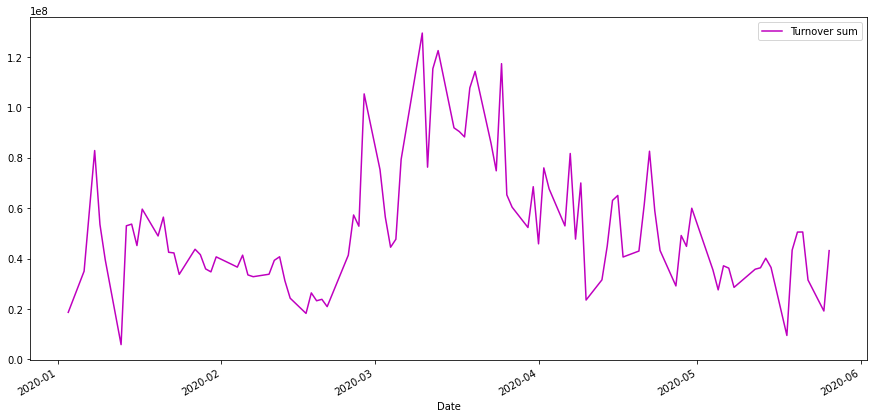

In [70]:
plt.figure(figsize=(15,7))
volume_df.groupby('Date')['Turnover'].sum()\
.plot(color='m',label='Turnover sum',legend=True)


## Total volume of day trades with rolling averages

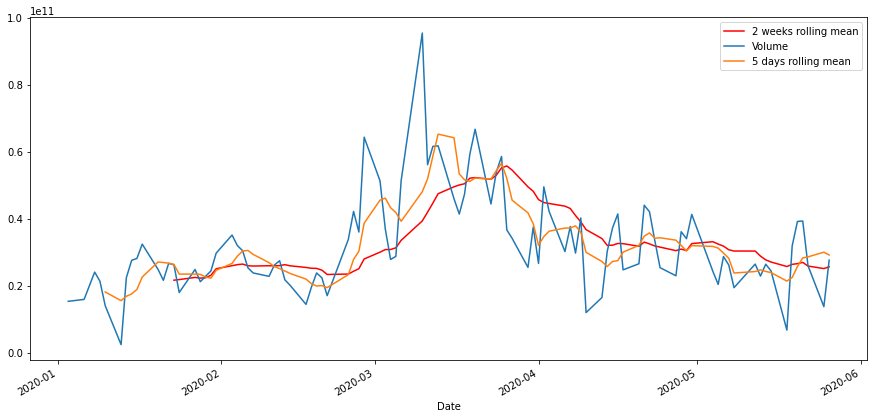

In [72]:
plt.figure(figsize=(15,7))
volume_df.groupby('Date')['Volume'].sum().rolling(14).mean().plot(legend=True, color='r',label="2 weeks rolling mean")
volume_df.groupby('Date')['Volume'].sum().plot(legend=True,label="Volume")
volume_df.groupby('Date')['Volume'].sum().rolling(5).mean().plot(legend=True,label="5 days rolling mean")
